In [149]:
# importing data manipulation as well as plotting packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# importing statistical packages
import statsmodels.api as sm
import scipy
from statsmodels.formula.api import ols

%matplotlib inline

# Discovery Passage Zooplankton Abundance


In [142]:
# Loading the dataset of zooplankton abundance
# Making the date column my index for ease of referencing in the future
zoo= pd.read_csv('../data/Zooplankton_2009-2012.csv', sep=',', index_col='Date')
zoo.index = pd.to_datetime(zoo.index, unit='m')


#Sentry Shoals Environment Canada Data


In [ ]:
# importing the environment canada data set with the date as the index column
gwv_data = pd.read_csv('../data/c46131.csv', sep=',', index_col='DATE')
gwv_data.index = pd.to_datetime(gwv_data.index, unit='m')

# Deleting empty columns to make data cleaner
del gwv_data['WSS$']
del gwv_data['WSS$.1']

The primary goal of this project is to compare Discovery passage zooplankton abundance with nearby Sentry Shoals sea surface temperature and significant wave height (proxy for vertical turnover). In order to do this I want to create a timeseries plot comparing the zooplankton abundance for a certain year to the significant wave height and the sea surface temperature. This plot will allow me to visually observe the trends of these three varaibles over the course of the spring bloom season. Then I will statistically compare these three varaibles using a few different tests. 

The largest problem with producing a timeseries plot from these datasets (Discovery Passage zooplankton and Sentry Shoals Environment Canada) is the mismatch in their observation frequencies. Therefore I made a function that would automatically munge the data and put it into a new dataframe for for further work such as plotting or statistical analysis. The function requires 6 inputs, the year desired, the names of both datasets, and the 3 column names of the varaibles of interest. The funcion first resamples both datasets on a weekly average to ensure unity in the timescale used for the date. Then the data is selected for only the spring bloom season. This time period is year specific and is determined by the timeline of plankton samples that year. Finally the data is inputted into the new datatable, where it can be used for further plotting or statistical analysis. Unfornately this function is limited to taking 2 columns from the first dataset, and only 1 from the second dataset. Thus, the column_1 and column_2 inputs are strictly for the first dataset's columns and the column_3 input is for the second dataset's columns. I hope to improve this model in the coming days by making it into a script  which can load the data as well.

Below, I use the function to make 4 datatables of the spring bloom season for the years of 2009-2012. Each datatable is composed of significant wave height, sea surface temperature and zooplankton abundance over this time. 

In [143]:
def spring_wk(dataset_1, dataset_2, year, column_1, column_2, column_3):
    '''This function will average data per week over the spring of 2012, 2011, 2010 or 
    2009 for my two datasets'''
    
    assert 2009 <= year <= 2012, 'Year should be between 2009 and 2012'
    assert len(dataset_1) > 1
    assert len(dataset_2) > 1
    # Ensuring dataset_1 index (time) is in pandas datetime format
    dataset_1.index = pd.to_datetime(dataset_1.index, unit='m')

    # Resampling the columns from dataset_1 into weekly averages
    column_1_weekly = column_1.resample('W', how=('mean'))
    column_2_weekly = column_2.resample('W', how=('mean'))
    
    # Subsetting the columns from dataset_1 for the spring plankton bloom in the specified year
    if year == 2009:
        first ='2009-02-24'
        last = '2009-07-05' 
    if year == 2010:
        first = '2010-03-03'
        last = '2010-6-28'   
    if year == 2011:
        first = '2011-03-07'
        last = '2011-07-03'
    if year == 2012:
        first ='2012-03-30'
        last = '2012-07-01'
    column_1_weekly_year = column_1_weekly[first:last]
    column_2_weekly_year = column_2_weekly[first:last]
    
    

    # dropping the rows where naN's are present in dataset_1
    column_1_weekly_year_new = column_1_weekly_year.dropna()
    column_2_weekly_year_new = column_2_weekly_year.dropna()
    
    # Ensuring dataset_2 index (time) in in pandas datetime format
    dataset_2.index = pd.to_datetime(dataset_2.index, unit='d')
    
    # Now resampling column from dataset_2 into weekly averages over the desired spring
    if year == 2009:
        yr = '2009'
    if year == 2010:
        yr = '2010'
    if year == 2011:
        yr = '2011'
    if year == 2012:
        yr = '2012'
    column_3_year = column_3[yr]
    column_3_year_weekly = column_3_year.resample('W', how=('mean'))
    
    # Combines the three columns across the two datasets into a single dataframe
    combination_data = pd.DataFrame({column_1.name : column_1_weekly_year_new, column_2.name : column_2_weekly_year_new, column_3.name : column_3_year_weekly})
    
    return combination_data

In [144]:
comb_2012 = spring_wk(gwv_data, zoo, 2012, gwv_data.sig_wave_height, gwv_data.sea_surface_temperature, zoo.Total_Zooplankton_Abundance)
comb_2011 = spring_wk(gwv_data, zoo, 2011, gwv_data.sig_wave_height, gwv_data.sea_surface_temperature, zoo.Total_Zooplankton_Abundance)
comb_2010 = spring_wk(gwv_data, zoo, 2010, gwv_data.sig_wave_height, gwv_data.sea_surface_temperature, zoo.Total_Zooplankton_Abundance)
comb_2009 = spring_wk(gwv_data, zoo, 2009, gwv_data.sig_wave_height, gwv_data.sea_surface_temperature, zoo.Total_Zooplankton_Abundance)

To show the progression and interaction of sea surface temperature, significant wave height, and zooplankton abundance, I use the 4 datatables above to graph a timeseries plot for each spring between 2009-2012 for the three variables. In order to make the code for these plots efficient and streamlined, I made a function that would plot a timeseries for any three general variables. The function requires 5 inputs; the dataset name, the three column names for the varaibles of interest, and the savename that the plot will be saved to. This function assumes that all data plotted is from one dataset. Additionally, the savename must be in quotations, and the varaible's must be in the format of dataset.column_name in order for the function to recognize them. 

In [145]:
def timeseries(dataset, variable_1, variable_2, variable_3, savename):
    '''Function plots any three varaibles into timeseries plot and saves plot '''
    # layering the three axes, which contain the three varaibles, on top of one another to create a single subplot
    # layering completed with twinx() method
    ax1 = plt.subplot()
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    # plotting the 3 variables into the predetermined plot outlined above
    # Setting the color and width of lines on the graph
    ax1.plot(dataset.index, variable_1, 'k-', linewidth =2)
    ax2.plot(dataset.index, variable_2, 'grey', linewidth=2)
    ax3.plot(dataset.index, variable_3, 'g-', linewidth=4)
    
    # moving the spine that the zooplankton was plotted onto towards the right so it isnt on top of the second spine(ax2)
    variable_3_spine = ax3.spines['right']
    variable_3_spine.set_position(('axes', 1.2))

    # Adjusting the color of the axes ticks to match line color
    ax1.yaxis.set_tick_params(labelcolor='k')
    ax2.yaxis.set_tick_params(labelcolor='grey')
    ax3.yaxis.set_tick_params(labelcolor='green')
    
    # Making axes labels, selecting their color, and selecting their size
    ax1.set_xlabel(dataset.index.name, fontsize=14, y=0)
    ax1.set_ylabel(variable_1.name, fontsize = 13, color ='k')
    ax2.set_ylabel(variable_2.name + '($^o$C)', fontsize = 13, color='grey')
    ax3.set_ylabel(variable_3.name + '(m$^3$)', fontsize = 13, color='g')
    
    plt.savefig(savename)

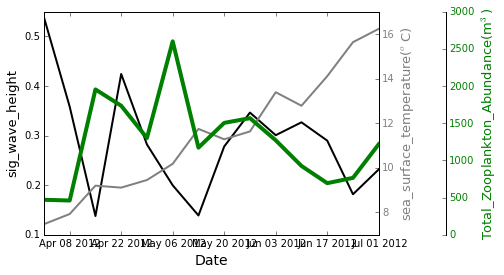

In [146]:
# testing this function for the year 2012
timeseries(comb_2012, comb_2012.sig_wave_height, comb_2012.sea_surface_temperature, comb_2012.Total_Zooplankton_Abundance, 'tseries_2012')

Unfortunatly I was not able to join of each of these plots together in the same panel. However I still wanted to do this for the final report, so I had to do it manually (without the function above). I would love some feedback on this. The code below is extremely long, very repetitive and I know their must be a better way that I just havent found.

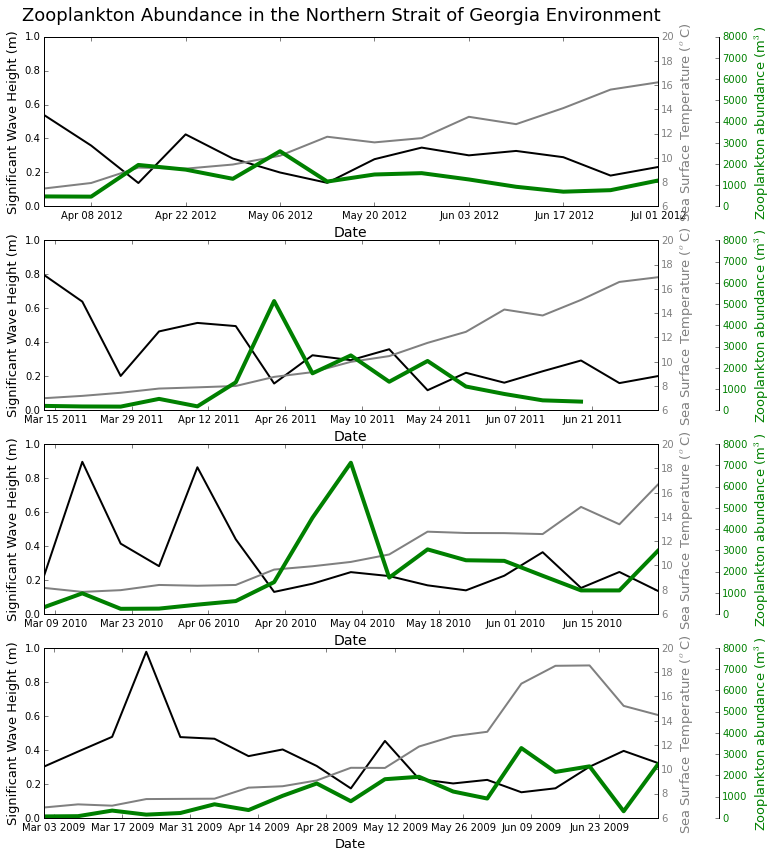

In [55]:
# Creating 4 timeseries subplots for the weekly averages of zooplankton abundance, sea surface temperature, and significant wave height during the springs of 2009-2012

# Adjusting the figure size
fig = plt.figure(figsize=(11, 14)) 

#Creating a super title for all of my subplots
plt.suptitle('Zooplankton Abundance in the Northern Strait of Georgia Environment', fontsize=18, y=0.93)

# CREATING THE FIRST SUBPLOT

# layering the three axes, which contain the three varaibles, on top of one another to create a single subplot
# layering completed with twinx() method
ax1 = plt.subplot(4,1,1)
ax2 = ax1.twinx()
ax3 = ax1.twinx()

# plotting the 3 variables into the predetermined plot outlined above
# Setting the color and width of lines on the graph
ax1.plot(comb_2012.index, comb_2012.column_1, 'k-', linewidth =2)
ax2.plot(comb_2012.index, comb_2012.column_2, 'grey', linewidth=2)
ax3.plot(comb_2012.index, comb_2012.column_3, 'g-', linewidth=4)

# moving the spine that the zooplankton was plotted onto towards the right so it isnt on top of the second spine(ax2)
column_3_spine = ax3.spines['right']
column_3_spine.set_position(('axes', 1.1))

# Adjusting the color of the axes ticks to match line color
ax1.yaxis.set_tick_params(labelcolor='k')
ax2.yaxis.set_tick_params(labelcolor='grey')
ax3.yaxis.set_tick_params(labelcolor='green')

# Setting the y limits (to Standardize across the subplots)
ax1.set_ylim([0, 1])
ax2.set_ylim([6, 20])
ax3.set_ylim([0, 8000])

# Making axes labels, selecting their color, and selecting their size
ax1.set_xlabel('Date', fontsize=14, y=0)
ax1.set_ylabel('Significant Wave Height (m)', fontsize = 13, color ='k')
ax2.set_ylabel('Sea Surface Temperature ($^o$C)', fontsize = 13, color='grey')
ax3.set_ylabel('Zooplankton abundance (m$^3$)', fontsize = 13, color='g')

# CREATING THE SECOND SUBPLOT

# layering the three axes, which contain the three varaibles, on top of one another to create a single subplot
# layering completed with twinx() method
ax4 = plt.subplot(4,1,2)
ax5 = ax4.twinx()
ax6 = ax4.twinx()

# plotting the 3 variables into the predetermined plot outlined above
# Setting the color and width of lines on the graph
ax4.plot(comb_2011.index, comb_2011.column_1, 'k-', linewidth =2)
ax5.plot(comb_2011.index, comb_2011.column_2, 'grey', linewidth=2)
ax6.plot(comb_2011.index, comb_2011.column_3, 'g-', linewidth=4)

# moving the spine that the zooplankton was plotted onto towards the right so it isnt on top of the second spine(ax2)
column_6_spine = ax6.spines['right']
column_6_spine.set_position(('axes', 1.1))

# Adjusting the color of the axes ticks to match line color
ax4.yaxis.set_tick_params(labelcolor='k')
ax5.yaxis.set_tick_params(labelcolor='grey')
ax6.yaxis.set_tick_params(labelcolor='green')

# Setting the y limits (to Standardize across the subplots)
ax4.set_ylim([0, 1])
ax5.set_ylim([6, 20])
ax6.set_ylim([0, 8000])

# Making axes labels, selecting their color, and selecting their size
ax4.set_xlabel('Date', fontsize=14, y=0)
ax4.set_ylabel('Significant Wave Height (m)', fontsize = 13, color ='k')
ax5.set_ylabel('Sea Surface Temperature ($^o$C)', fontsize = 13, color='grey')
ax6.set_ylabel('Zooplankton abundance (m$^3$)', fontsize = 13, color='g')

# CREATING THE THIRD SUBPLOT

# layering the three axes, which contain the three varaibles, on top of one another to create a single subplot
# layering completed with twinx() method
ax7 = plt.subplot(4,1,3)
ax8 = ax7.twinx()
ax9 = ax7.twinx()

# plotting the 3 variables into the predetermined plot outlined above
# Setting the color and width of lines on the graph
ax7.plot(comb_2010.index, comb_2010.column_1, 'k-', linewidth =2)
ax8.plot(comb_2010.index, comb_2010.column_2, 'grey', linewidth=2)
ax9.plot(comb_2010.index, comb_2010.column_3, 'g-', linewidth=4)

# moving the spine that the zooplankton was plotted onto towards the right so it isnt on top of the second spine(ax2)
column_9_spine = ax9.spines['right']
column_9_spine.set_position(('axes', 1.1))

# Adjusting the color of the axes ticks to match line color
ax7.yaxis.set_tick_params(labelcolor='k')
ax8.yaxis.set_tick_params(labelcolor='grey')
ax9.yaxis.set_tick_params(labelcolor='green')

# Setting the y limits (to Standardize across the subplots)
ax7.set_ylim([0, 1])
ax8.set_ylim([6, 20])
ax9.set_ylim([0, 8000])

# Making axes labels, selecting their color, and selecting their size
ax7.set_xlabel('Date', fontsize=14, y=0)
ax7.set_ylabel('Significant Wave Height (m)', fontsize = 13, color ='k')
ax8.set_ylabel('Sea Surface Temperature ($^o$C)', fontsize = 13, color='grey')
ax9.set_ylabel('Zooplankton abundance (m$^3$)', fontsize = 13, color='g')

# CREATING THE FOURTH SUBPLOT

# layering the three axes, which contain the three varaibles, on top of one another to create a single subplot
# layering completed with twinx() method
ax10= plt.subplot(4,1,4)
ax11= ax10.twinx()
ax12= ax10.twinx()

# Setting the color and width of lines on the graph
ax10.plot(comb_2009.index, comb_2009.column_1, 'k-', linewidth =2)
ax11.plot(comb_2009.index, comb_2009.column_2, 'grey', linewidth=2)
ax12.plot(comb_2009.index, comb_2009.column_3, 'g-', linewidth=4)

# moving the spine that the zooplankton was plotted onto towards the right so it isnt on top of the second spine(ax2)
column_12_spine = ax12.spines['right']
column_12_spine.set_position(('axes', 1.1))

# Adjusting the color of the axes ticks to match line color
ax10.yaxis.set_tick_params(labelcolor='k')
ax11.yaxis.set_tick_params(labelcolor='grey')
ax12.yaxis.set_tick_params(labelcolor='green')

# Setting the y limits (to Standardize across the subplots)
ax10.set_ylim([0, 1])
ax11.set_ylim([6, 20])
ax12.set_ylim([0, 8000])

# Making axes labels, selecting their color, and selecting their size
ax10.set_xlabel('Date', fontsize=13, y=0)
ax10.set_ylabel('Significant Wave Height (m)', fontsize = 13, color ='k')
ax11.set_ylabel('Sea Surface Temperature ($^o$C)', fontsize = 13, color='grey')
ax12.set_ylabel('Zooplankton abundance (m$^3$)', fontsize = 13, color='g')


# Showing the plot
plt.show()
    

# Statistics

While my project centers on the affects of environmental conditions on plankton abundance it is important to understand the interaction between these evironmental conditions since it is this interaction and not one condition alone that dictates plankton abundance. Therefore I will give a breif statistical analysis of the relationship between sea surface temperature and significant wave height. I begin by using my data munging function to subset that data for the years of 2009-2012 (Zooplankton collection years), then I use my linear model plot function and linear regression model to plot the line of best fit onto the scatter plot of sea surface temperature and significant wave height. Finally, I use my linear model function to produce a table of important statistics and indicate the strength of this relationship.

In [179]:
def data_munge_monthly(dataset, column_1, column_2):
    '''Function munges data by resampling into monthly means,  
    subsetting over the zooplankton collection years and inputting 
    columns into a new table'''

    # Changing the data index (time) into pandas datetime format
    dataset.index = pd.to_datetime(dataset.index, unit='m')

    # Collapsing the data so that all data are averaged over an annual perdiod
    column_1_monthly = column_1.resample('M', how=('mean'))
    column_2_monthly = column_2.resample('M', how=('mean'))

    # Subsetting the data for the last 11 years (this is the time period for which the plankton data have been collected)
    column_1_monthly_modern = column_1_monthly['2009-01-01':'2012-10-31']
    column_2_monthly_modern = column_2_monthly['2009-01-01':'2012-10-31']

    # dropping the rows where naN's are present in anticipation of calculating the linear model
    column_1_monthly_modern = column_1_monthly_modern.dropna()
    column_2_monthly_modern = column_2_monthly_modern.dropna()
    
    # Combines both columns into one dataset
    combination_data = pd.DataFrame({column_1.name : column_1_monthly_modern, column_2.name : column_2_monthly_modern})
    return combination_data

In [180]:
# Executing data munge function for sea surface temperature and significant wave height
background = data_munge_monthly(gwv_data, gwv_data.sea_surface_temperature, gwv_data.sig_wave_height)

In [194]:

def linear_model_plot(x_variable, y_variable):
    '''Function develops and plots linear model'''
    # assigning function variables to response and predictor variables
    y = y_variable # response
    X = x_variable # predictor
    X = sm.add_constant(X)  # Adds a constant term to the predictor (essential to obtain the constant in the formula)
    
    # Calculating the linear model for the two variables
    lm = sm.formula.OLS(y, X).fit()
    
    # Developing the plot of the linear model
    # making a range of the x variable to pass to the y prediction
    x_pred = np.linspace(x_variable.min(), x_variable.max())
    
    # Adding a constant to this range of x values (essential to obtain the constant in the formula)
    x_pred2 = sm.add_constant(x_pred)

    # Passing the linear model predictor the range of x values to model over
    y_pred = lm.predict(x_pred2)

    # Plotting these predicitons on the graph
    plt.plot(x_pred, y_pred, color='k', linewidth=2)

    

    # Obtaining linear regression 
    return plt.plot()

In [197]:
def linear_regression(x_variable, y_variable):
    '''This function produces a plot showing the linear 
    regression line between two specified varaibles '''
    
    # adjusting the figure size
    fig = plt.figure(figsize=(10, 7)) 
    # Creating a title for the plot
    plt.title(x_variable.name, fontsize=16, y=1.01)
    
    # Plroducing scatter plot of relationship between two varaibles
    plt.scatter(x_variable, y_variable)
    
    # Creates the linear model and applies linear regression to subplot
    linear_model_plot(x_variable, y_variable)
    
    
    # Creating axis labels and title
    plt.ylabel(x_variable.name)
    plt.xlabel(y_variable.name)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


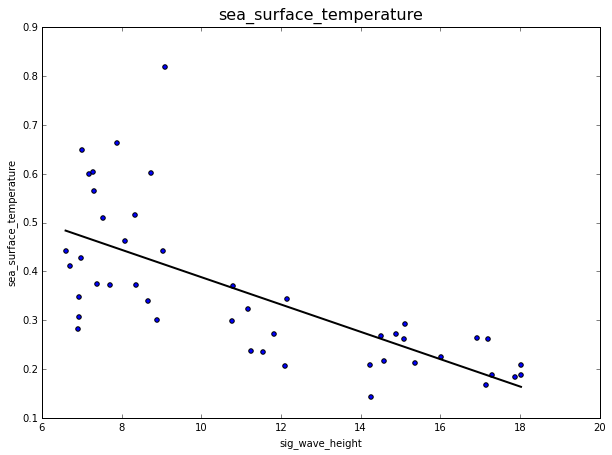

In [198]:
# Executing linear regression model for munged sea surface temperature and significant wave height data
linear_regression(background.sea_surface_temperature, background.sig_wave_height)

In [192]:
def linear_model(x_variable, y_variable):
    '''Function creates linear model and produces 
    a statistical summary'''
    
     # assigning function variables to response and predictor variables
    y = y_variable # response
    X = x_variable # predictor
    X = sm.add_constant(X)  # Adds a constant term to the predictor (essential to obtain the constant in the formula)
    
    # Producing the linear model
    lm = sm.formula.OLS(y, X).fit()
    
    # returning the linear model's summary
    return lm.summary()

In [193]:
# Executing the linear model function for munged sea surface temperature and significant wave height data
linear_model(background.sea_surface_temperature, background.sig_wave_height)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sig_wave_height   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     43.30
Date:                Mon, 16 Nov 2015   Prob (F-statistic):           4.73e-08
Time:                        08:38:57   Log-Likelihood:                 36.564
No. Observations:                  46   AIC:                            -69.13
Df Residuals:                      44   BIC:                            -65.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                       0.6684      0.051     13.194      0.000         0.566     0.770
sea_surface_temperature    -0.0280      0.004     -6.580      0.000        -0.037    -0.019
==============================================================================
Omnibus:                       16.015   Durbin-Watson:                   2.510
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.959
Skew:                           1.146   Prob(JB):                     2.81e-05
Kurtosis:                       5.385   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The series of functions above is great for producing linear models and lines of best fit between two varaibles, however I have three variables of interest; sea surface temperature, significant wave height, and zooplankton abundance. Therefore I need to multivariate liner regression to explore the statistical relationship between my three variables. The code for this multivaraite linear regression is below, however I have yet to develop a general formula for this multivaraite linear regression. In the cells below I have individually produced 4 different statistical summaries(one for each year between 2009 and 2012) for the multivariate interactions between sea surface temperature significant wave height and zooplankton abundance. These plots were created from the results of my spring week function which are composed of weekly averaged data for the spring bloom season. Moving forward I woould like to find a general code that would produce these summaries and plot the linear regression for any 3 varaibles. 

In [152]:
# multivariate regression and summary for 2012
lm=ols('Total_Zooplankton_Abundance ~ sea_surface_temperature * sig_wave_height', data=comb_2012).fit() 

print(lm.summary())


                                 OLS Regression Results                                
Dep. Variable:     Total_Zooplankton_Abundance   R-squared:                       0.403
Model:                                     OLS   Adj. R-squared:                  0.224
Method:                          Least Squares   F-statistic:                     2.253
Date:                         Sun, 15 Nov 2015   Prob (F-statistic):              0.145
Time:                                 23:17:29   Log-Likelihood:                -105.18
No. Observations:                           14   AIC:                             218.4
Df Residuals:                               10   BIC:                             220.9
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------

//anaconda/lib/python3.4/site-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  int(n))


In [154]:
# multivariate regression and summary for 2011
lm=ols('Total_Zooplankton_Abundance ~ sea_surface_temperature * sig_wave_height', data=comb_2011).fit() #Specify C for Categorical

print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:     Total_Zooplankton_Abundance   R-squared:                       0.366
Model:                                     OLS   Adj. R-squared:                  0.208
Method:                          Least Squares   F-statistic:                     2.313
Date:                         Sun, 15 Nov 2015   Prob (F-statistic):              0.128
Time:                                 23:18:02   Log-Likelihood:                -133.21
No. Observations:                           16   AIC:                             274.4
Df Residuals:                               12   BIC:                             277.5
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------

//anaconda/lib/python3.4/site-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  int(n))


In [155]:
# multivariate regression and summary for 2010
lm=ols('Total_Zooplankton_Abundance ~ sea_surface_temperature * sig_wave_height', data=comb_2010).fit() #Specify C for Categorical

print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:     Total_Zooplankton_Abundance   R-squared:                       0.148
Model:                                     OLS   Adj. R-squared:                 -0.049
Method:                          Least Squares   F-statistic:                    0.7528
Date:                         Sun, 15 Nov 2015   Prob (F-statistic):              0.540
Time:                                 23:18:18   Log-Likelihood:                -149.61
No. Observations:                           17   AIC:                             307.2
Df Residuals:                               13   BIC:                             310.6
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------

//anaconda/lib/python3.4/site-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  int(n))


In [157]:
# multivariate regression and summary for 2009
lm=ols('Total_Zooplankton_Abundance ~ sea_surface_temperature * sig_wave_height', data=comb_2009).fit() #Specify C for Categorical

print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:     Total_Zooplankton_Abundance   R-squared:                       0.611
Model:                                     OLS   Adj. R-squared:                  0.533
Method:                          Least Squares   F-statistic:                     7.842
Date:                         Sun, 15 Nov 2015   Prob (F-statistic):            0.00222
Time:                                 23:18:36   Log-Likelihood:                -148.17
No. Observations:                           19   AIC:                             304.3
Df Residuals:                               15   BIC:                             308.1
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------

//anaconda/lib/python3.4/site-packages/scipy/stats/stats.py:1233: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  int(n))
